In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Processing task: new_lupus
Unique architectures found: ['bert' 'llama' 'mamba' 'hyena' 'gpt2']
    sub_task            model  k  score     value architecture  \
0  new_lupus    bert-base-512 -1  auroc  0.597256         bert   
1  new_lupus    gpt2-base-512 -1  auroc  0.718511         gpt2   
2  new_lupus   llama-base-512 -1  auroc  0.725956        llama   
3  new_lupus  mamba-tiny-1024 -1  auroc  0.719073        mamba   
4  new_lupus   gpt2-base-1024 -1  auroc  0.735110         gpt2   

   context_length  task_name  
0             512  new_lupus  
1             512  new_lupus  
2             512  new_lupus  
3            1024  new_lupus  
4            1024  new_lupus  
Processing task: new_hypertension
Unique architectures found: ['bert' 'llama' 'mamba' 'hyena' 'gpt2']
    sub_task            model  k  score     value architecture  \
0  new_lupus    bert-base-512 -1  auroc  0.597256         bert   
1  new_lupus    gpt2-base-512 -1  auroc  0.718511         gpt2   
2  new_lupus   llama-b

/var/folders/7j/z3ypktfd6kl1c5n4dbch9y580000gp/T/ipykernel_37476/2529069203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].str.split('--clmbr_train').str[0]
/var/folders/7j/z3ypktfd6kl1c5n4dbch9y580000gp/T/ipykernel_37476/2529069203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].str.split('--clmbr_train').str[0]
/var/folders/7j/z3ypktfd6kl1c5n4dbch9y580000gp/T/ipykernel_37476/2529069203.py:6: SettingWithCopyWarning: 
A value is trying to be set o

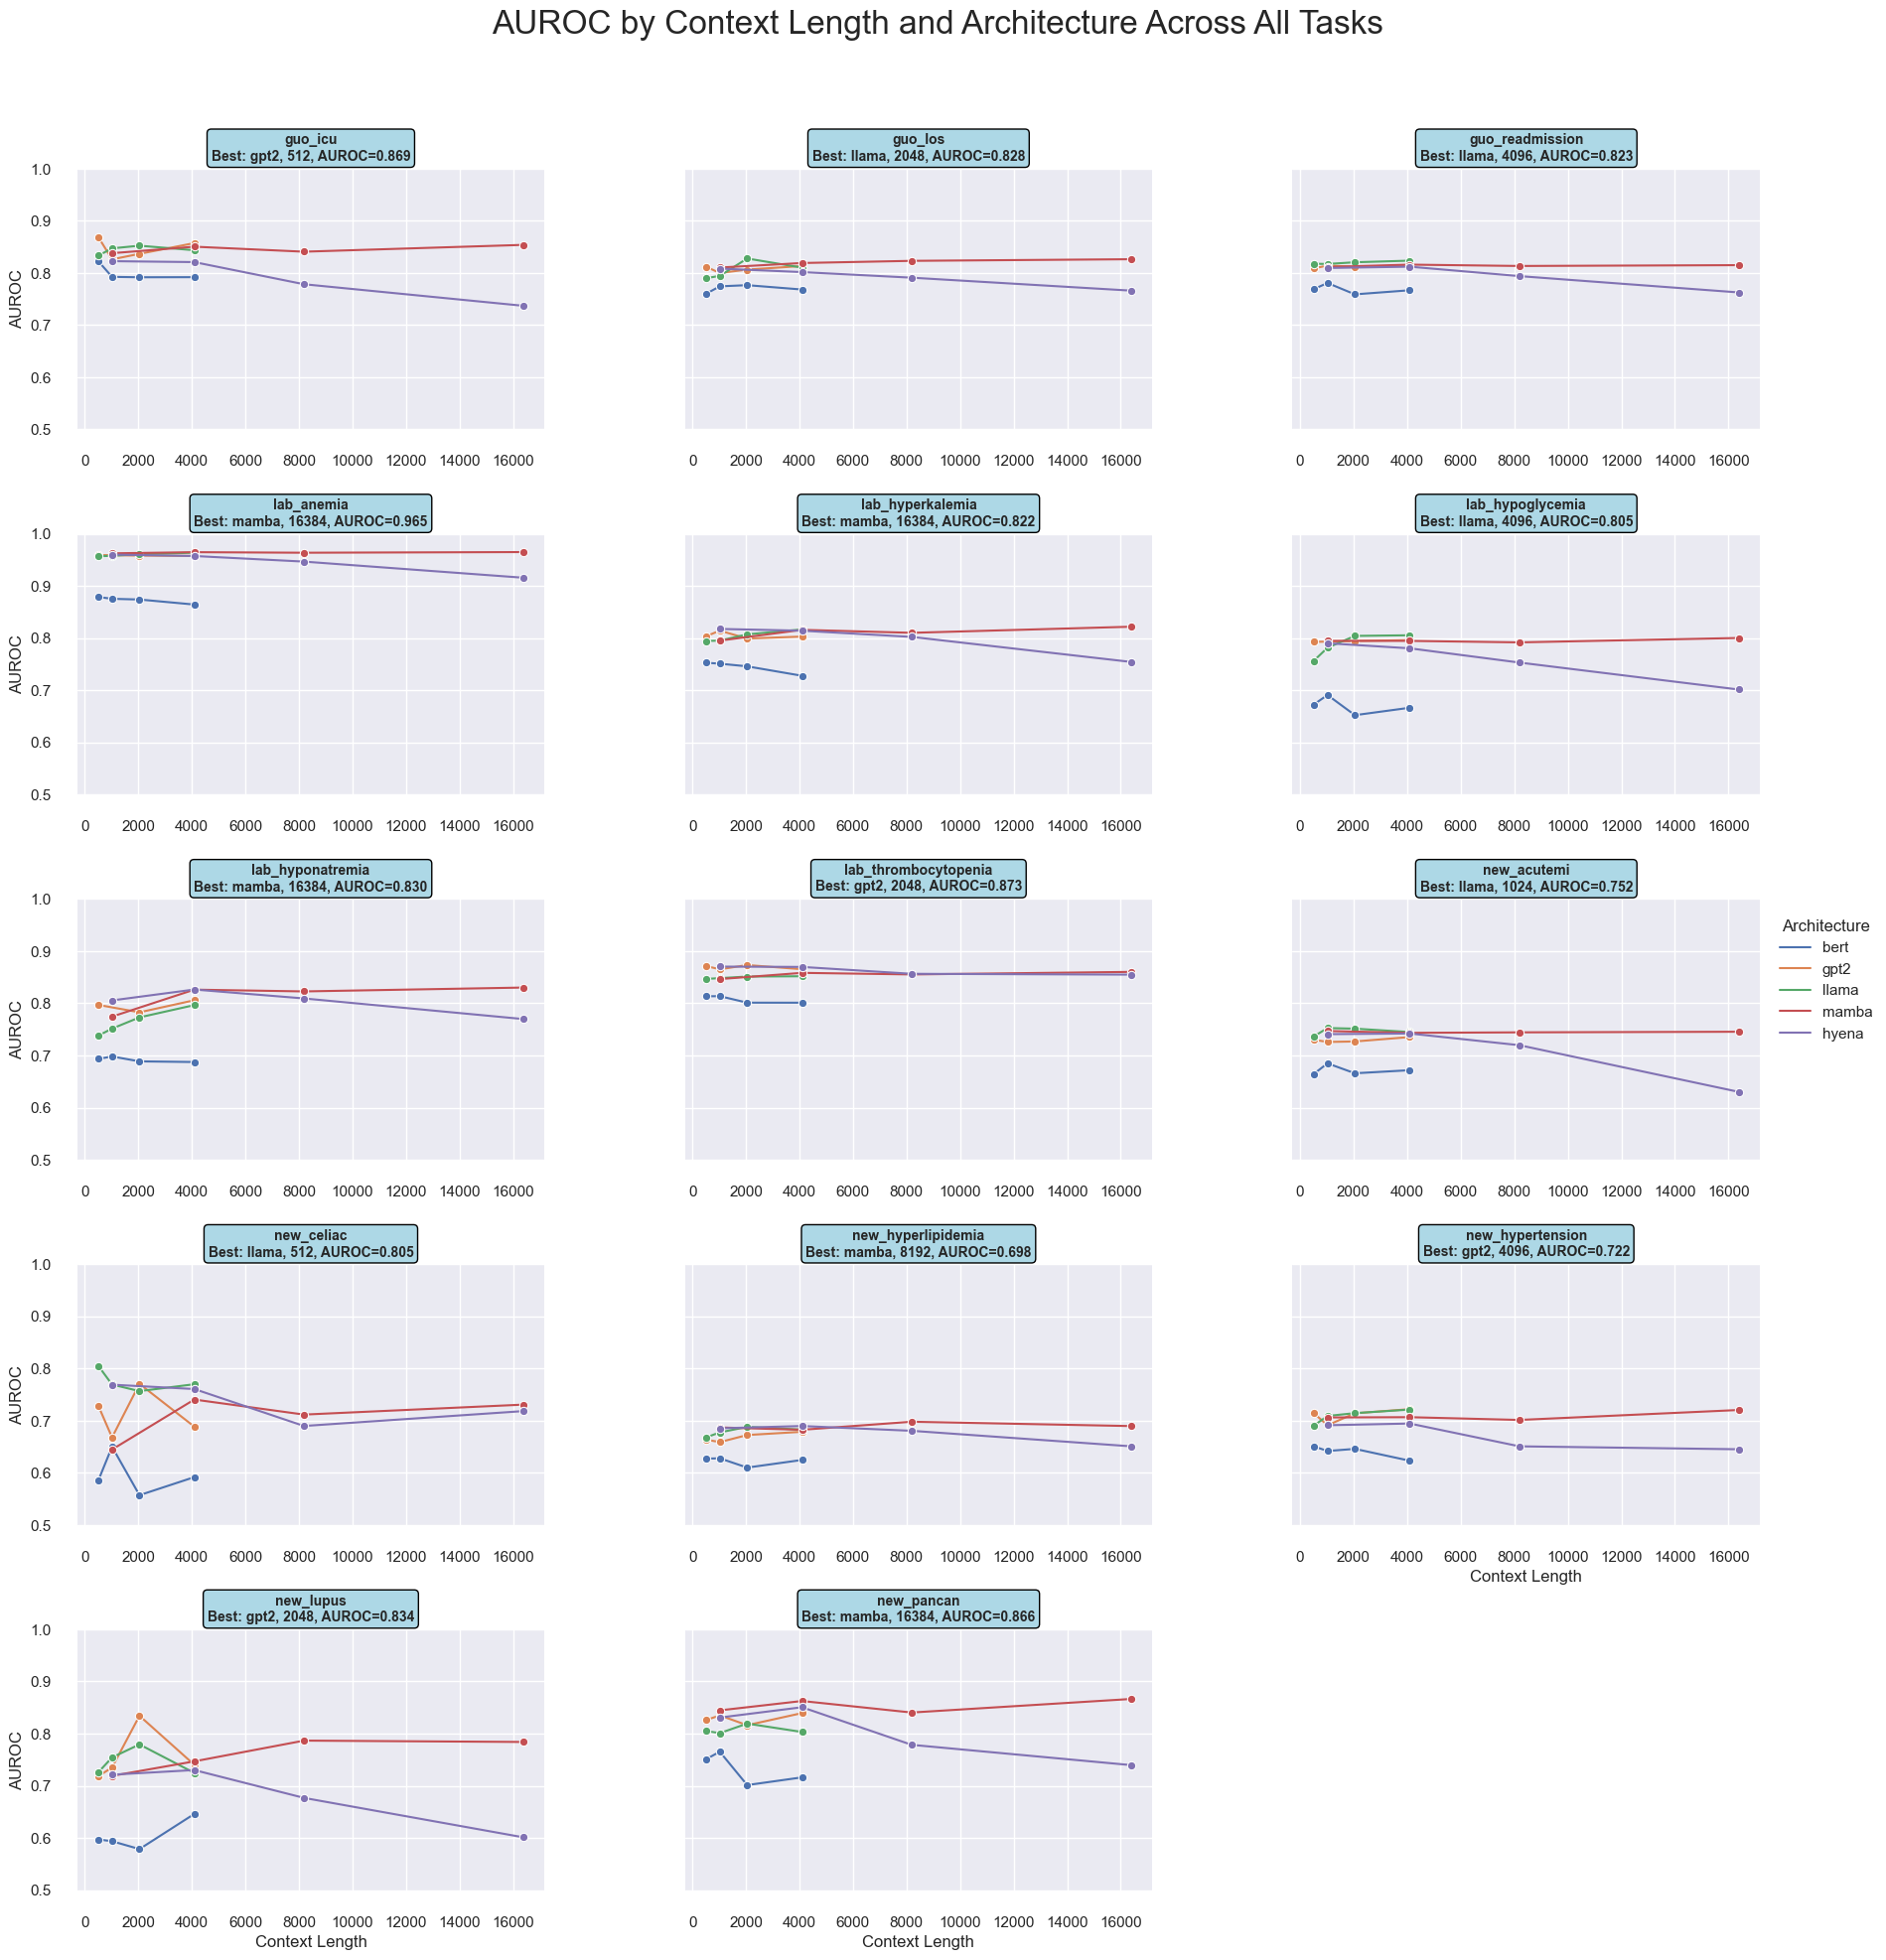

In [8]:
# Function to clean and extract relevant information from the CSV
## This is assuming there is a directory named ehrshot with subdirectories named after the tasks and csvs nested within them 
def clean_and_extract(df):
    # Select and clean relevant columns
    df = df[['sub_task', 'model', 'k', 'score', 'value']]
    df['model'] = df['model'].str.split('--clmbr_train').str[0]
    
    # Filter for AUROC scores and remove duplicates
    df = df[(df['k'] == -1) & (df['score'] == 'auroc')].drop_duplicates()
    
    # Extract architecture and context length
    # Ensure that architectures like 'bert' and 'llama' are correctly recognized
    df['architecture'] = df['model'].apply(lambda x: x.split('-')[0])
    
    # Extract context length safely and ensure it's an integer
    df['context_length'] = df['model'].apply(lambda x: int(x.split('-')[2]) if len(x.split('-')) > 2 and x.split('-')[2].isdigit() else None)
    
    # Check if the architecture extraction is working properly
    print(f"Unique architectures found: {df['architecture'].unique()}")

    # Filter out rows related to GPT vocab size variations
    df = df[~df['model'].str.contains('--clmbr-')]
    
    return df

# Function to combine summaries and add task names
def process_all_tasks_for_plotting():
    current_dir = os.getcwd()
    ehrshot_dir = os.path.join(current_dir, 'ehrshot')  # Point to the 'ehrshot' directory
    combined_summary = pd.DataFrame()
    
    for task_name in os.listdir(ehrshot_dir):
        task_path = os.path.join(ehrshot_dir, task_name)
        if os.path.isdir(task_path) and task_name != 'chexpert':  # Exclude "chexpert"
            try:
                print(f"Processing task: {task_name}")
                # Read and clean data
                input_file = os.path.join(task_path, 'all_results.csv')
                df = pd.read_csv(input_file)
                df_cleaned = clean_and_extract(df)
                
                # Sort context lengths numerically, then convert to string
                df_cleaned['context_length'] = df_cleaned['context_length'].astype(int)
                df_cleaned = df_cleaned.sort_values('context_length')
                
                # Add task name to the summary
                df_cleaned['task_name'] = task_name
                
                # Combine with the overall summary
                combined_summary = pd.concat([combined_summary, df_cleaned], ignore_index=True)
                print(combined_summary.head())  # Debug: Inspect the first few rows
                
            except Exception as e:
                print(f"Failed to process task {task_name}: {e}")
    
    return combined_summary

def plot_all_tasks_in_one_frame(combined_summary, save_path):
    # Set the Seaborn style for a dark grid background
    sns.set(style="darkgrid")
    
    # Sort context lengths uniformly
    combined_summary = combined_summary.sort_values('context_length')
    
    # Ensure all tasks have the same context lengths by adding missing ones with NaN
    context_lengths = combined_summary['context_length'].unique()
    architectures = combined_summary['architecture'].unique()
    
    # Reindex for each task to ensure consistency in context lengths
    reindexed_data = []
    for task_name, task_data in combined_summary.groupby('task_name'):
        task_data = task_data.set_index(['context_length', 'architecture']).reindex(
            pd.MultiIndex.from_product([context_lengths, architectures], names=['context_length', 'architecture']),
            fill_value=np.nan
        ).reset_index()
        task_data['task_name'] = task_name
        reindexed_data.append(task_data)
    
    combined_summary = pd.concat(reindexed_data, ignore_index=True)
    
    # Facet grid with one plot per task
    g = sns.FacetGrid(combined_summary, col="task_name", col_wrap=3, height=4, aspect=1.5, sharey=True, sharex=True, despine=False)
    
    # Plotting the line plots with architecture as hue
    g.map(sns.lineplot, "context_length", "value", "architecture", marker='o', errorbar=None)
    
    # Ensure all subplots have the same y-axis scale with a minimum of 0.6 and maximum of 1.0
    g.set(ylim=(0.5, 1.0))
    
    # Set axis labels
    g.set_axis_labels("Context Length", "AUROC")
    
    # Add the legend for the models (architectures)
    g.add_legend(title="Architecture")
    
    for i, (task_name, task_data) in enumerate(combined_summary.groupby("task_name")):
        ax = g.axes.flat[i]
        
        # Find the row with the highest AUROC
        best_row = task_data.loc[task_data['value'].idxmax()]
        best_architecture = best_row['architecture']
        best_context_length = best_row['context_length']
        best_auroc = best_row['value']
        
        # Set the title of each subplot to include this information, enclosed in a box
        ax.set_title(
            f"{task_name}\nBest: {best_architecture}, {best_context_length}, AUROC={best_auroc:.3f}",
            fontsize=10,
            fontweight='bold',  # Make text bold
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3')  # Colored box
        )
        
        if i % 3 == 0:  # Only display y-ticks for the first plot in each row
            ax.yaxis.set_tick_params(labelleft=True)
        else:
            ax.yaxis.set_tick_params(labelleft=False)
        
        ax.tick_params(axis='both', which='both', length=5)  # Ensure ticks are visible
        sns.despine(ax=ax, offset=10, trim=True)  # Apply a nice border to each subplot
    
    # Adjust layout to fit the title and increase spacing between subplots
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
    g.fig.suptitle('AUROC by Context Length and Architecture Across All Tasks', fontsize=24)
    
    # Save the figure
    g.savefig(save_path)
    
    # Show the plot
    plt.show()

# First, process all tasks and get the combined summary
combined_summary = process_all_tasks_for_plotting()

# Then, plot all tasks in one frame and save the figure
plot_all_tasks_in_one_frame(combined_summary, "auroc_by_context_length_and_architecture_fixed.png")
